In [17]:
import torch
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
import importlib

from datasets import MuscimaObjects
from datasets.MuscimaObjects import get_transform
from datasets.MuscimaMeasures import visualize_bboxes

from semantics.SystemObjects import *

In [18]:
# load the measures model
SAVED_MODEL_MEASURES = os.path.join('saved_models', 'measures_5_layers.pt')
model = torch.load(SAVED_MODEL_MEASURES)
model.eval()
# load the object annotations
MUSCIMAROOT = 'muscima'
dataset = MuscimaObjects.MuscimaObjects(MUSCIMAROOT, MuscimaObjects.__pitch_objects__, get_transform(train=True))
dataset_test = MuscimaObjects.MuscimaObjects(MUSCIMAROOT, MuscimaObjects.__pitch_objects__, get_transform(train=False))
#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])


In [19]:
image_index = 0

image, target = dataset_test[image_index]

In [43]:
image.type() == 'torch.FloatTensor'

True

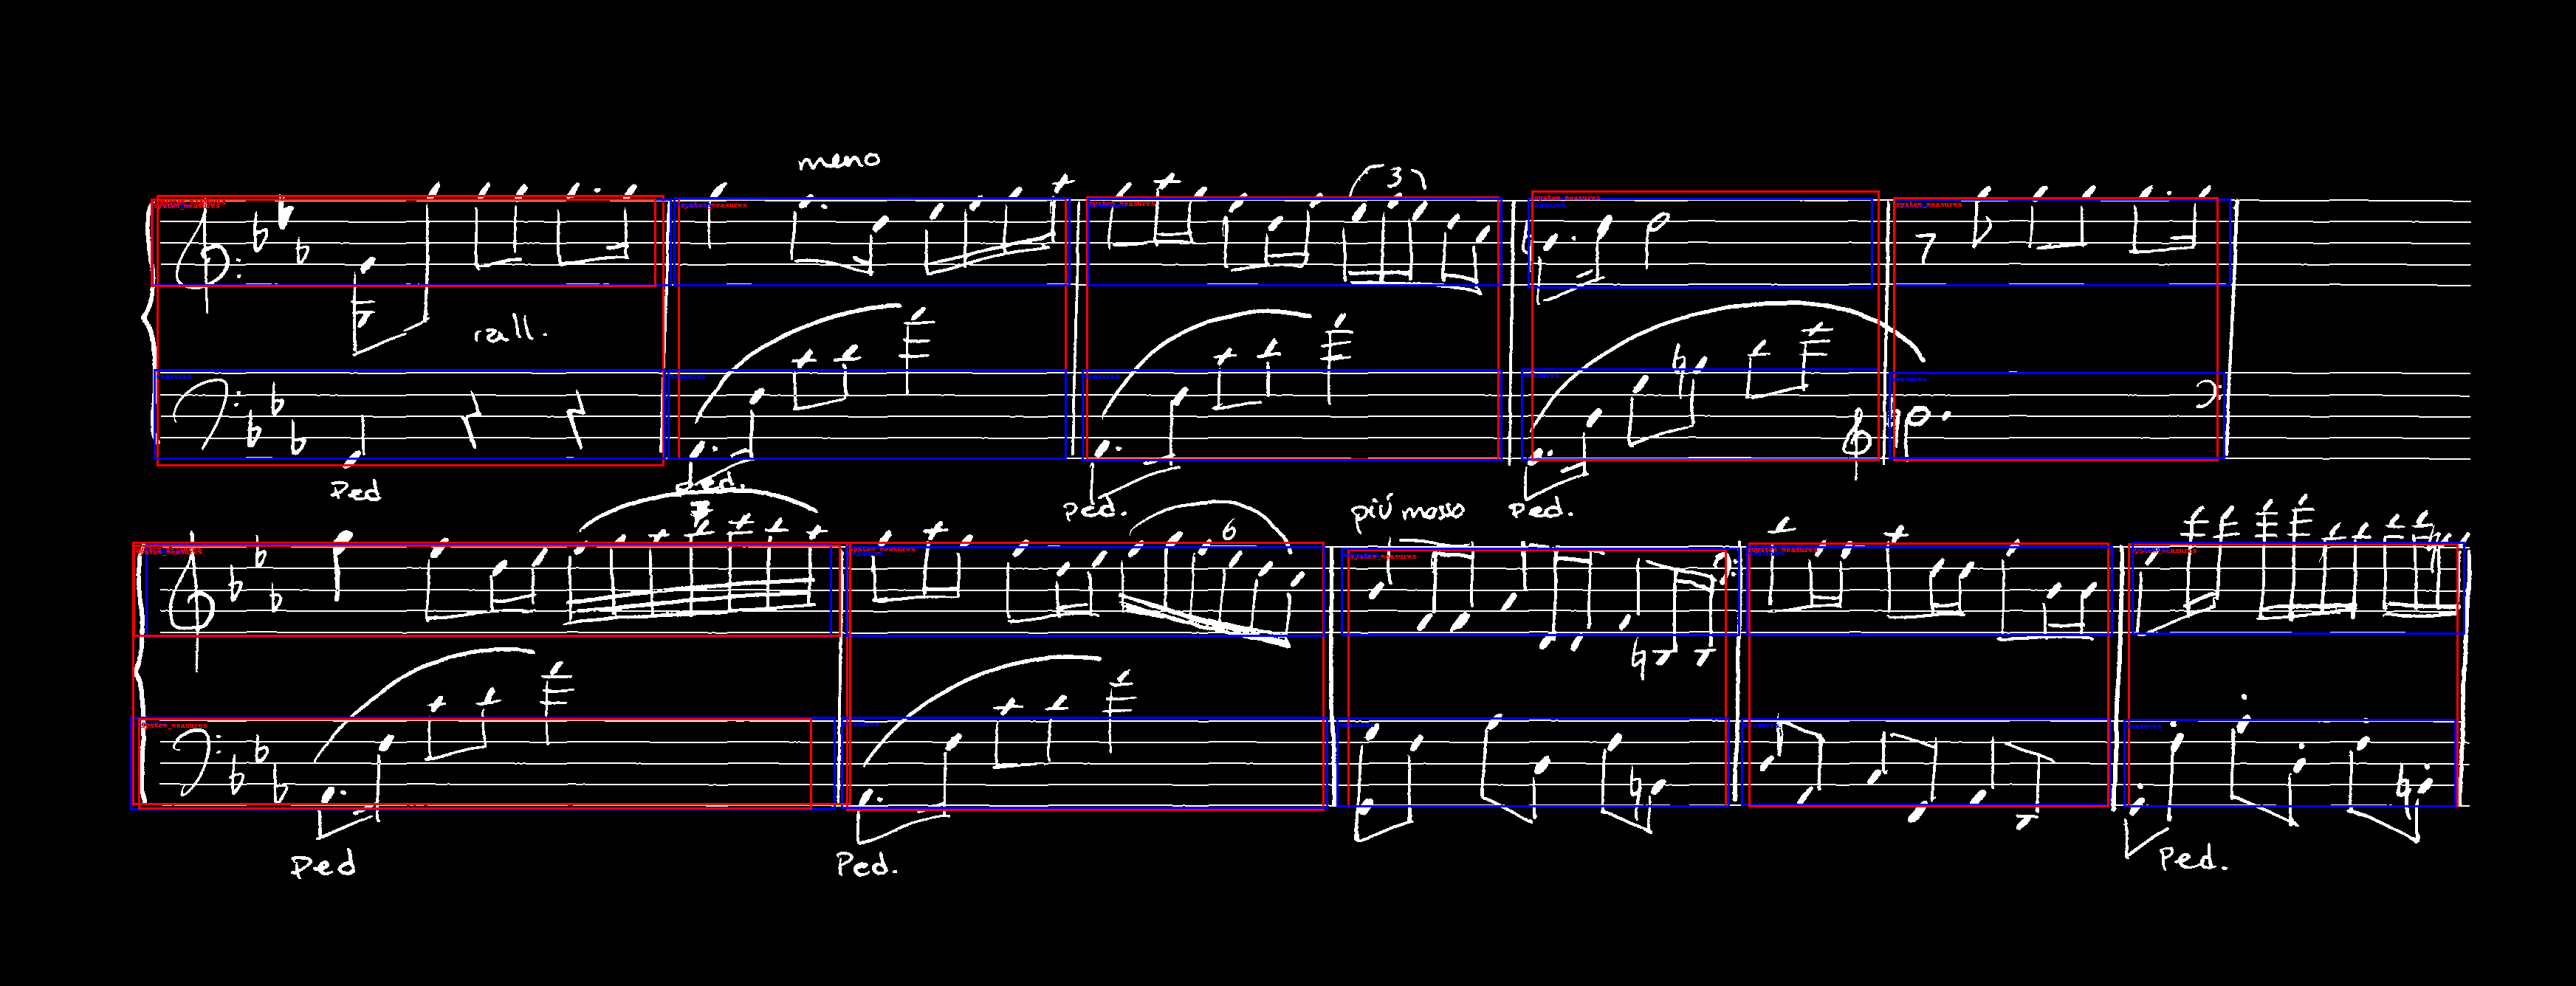

In [20]:
sample_image = [np.repeat(image, 3, 0)]
images = list(img.to(torch.device('cuda')) for img in sample_image)
detections = model(images)

visualize_bboxes(images[0], detections[0])

In [21]:
MuscimaObjects.__pitch_objects__

['noteheadFull',
 'noteheadHalf',
 'noteheadWhole',
 'accidentalSharp',
 'accidentalFlat',
 'accidentalNatural',
 'gCflef',
 'fClef',
 'cClef']

In [47]:
height, width = images[0].shape[1:3]

# filter unreliable results
THRESHOLD = 0.75
best_boxes = torch.where(detections[0]['scores'] > THRESHOLD)

detections_reduced = {}
detections_reduced['boxes'] = detections[0]['boxes'][best_boxes]
detections_reduced['labels'] = detections[0]['labels'][best_boxes]
detections_reduced['scores'] = detections[0]['scores'][best_boxes]

# get system measures and staff measures
system_measures = detections_reduced['boxes'][torch.where(detections_reduced['labels'] == 1)]
staff_measures = detections_reduced['boxes'][torch.where(detections_reduced['labels'] == 2)]

# move tensors to CPU
system_measures = system_measures.cpu().detach().numpy()
staff_measures = staff_measures.cpu().detach().numpy()

In [48]:
# normalize
staff_measures[:,[1,3]] = staff_measures[:,[1,3]]/height
staff_measures[:,[0,2]] = staff_measures[:,[0,2]]/width

system_measures[:,[1,3]] = system_measures[:,[1,3]]/height
system_measures[:,[0,2]] = system_measures[:,[0,2]]/width

# sort by y axis (ascending)
sort_order = np.argsort(staff_measures[:,1])
staff_measures = staff_measures[sort_order]

sort_order = np.argsort(system_measures[:,1])
system_measures = system_measures[sort_order]

In [49]:
staff_measures

array([[0.26157737, 0.20014504, 0.41555455, 0.28993124],
       [0.42241842, 0.20099302, 0.58305895, 0.28973627],
       [0.5932687 , 0.20101881, 0.72710514, 0.291963  ],
       [0.7352904 , 0.20161884, 0.86598116, 0.28968045],
       [0.05888305, 0.20185809, 0.26053712, 0.28969795],
       [0.59070754, 0.37419364, 0.7296071 , 0.46695033],
       [0.05971682, 0.37450802, 0.25843462, 0.46590468],
       [0.420092  , 0.374791  , 0.58300257, 0.4671924 ],
       [0.25922823, 0.37479445, 0.41415334, 0.46614403],
       [0.7334418 , 0.37778202, 0.8635829 , 0.46550924],
       [0.82746017, 0.55014384, 0.9568921 , 0.64357543],
       [0.05652345, 0.5515011 , 0.32300988, 0.64646804],
       [0.67806345, 0.55410665, 0.820191  , 0.645066  ],
       [0.32837382, 0.5546115 , 0.51439744, 0.64573956],
       [0.52063066, 0.55594516, 0.67527044, 0.6445135 ],
       [0.05049832, 0.72714096, 0.32430235, 0.82129073],
       [0.3265667 , 0.7271929 , 0.5156052 , 0.8196399 ],
       [0.51883245, 0.72778434,

In [50]:
staves = []
firstStaff = Staff()
staves.append(firstStaff)
for i in range(staff_measures.shape[0]):
    if staves[-1].append(staff_measures[i]) is True:
        pass
    else:
        nextstaff = Staff()
        staves.append(nextstaff) 
        staves[-1].append(staff_measures[i])


sample_staff = staves[1]
        
print(sample_staff.getStats())
print(sample_staff.getStaffLinesBBs())

stafflineBBs = sample_staff.getStaffLinesBBs()
stafflineBBs[:,[1,3]] = stafflineBBs[:,[1,3]]*height
stafflineBBs[:,[0,2]] = stafflineBBs[:,[0,2]]*width

{'top': 0.37521383, 'bottom': 0.46634012, 'left': 0.059716824, 'right': 0.8635829, 'center': 0.42077697813510895, 'num': 5}
[[0.05971682 0.37521383 0.86358291 0.3979954 ]
 [0.05971682 0.3979954  0.86358291 0.42077698]
 [0.05971682 0.42077698 0.86358291 0.44355855]
 [0.05971682 0.44355855 0.86358291 0.46634012]]


In [53]:
for staff in staves:
    print(staff)

staves.sort()
for staff in staves:
    print(staff)

{'top': 0.728073, 'bottom': 0.8190278, 'left': 0.050498318, 'right': 0.9535197, 'center': 0.7735503911972046, 'num': 5}
{'top': 0.55326164, 'bottom': 0.6450726, 'left': 0.056523446, 'right': 0.9568921, 'center': 0.5991671085357666, 'num': 5}
{'top': 0.37521383, 'bottom': 0.46634012, 'left': 0.059716824, 'right': 0.8635829, 'center': 0.42077697813510895, 'num': 5}
{'top': 0.20112677, 'bottom': 0.2902018, 'left': 0.05888305, 'right': 0.86598116, 'center': 0.2456642910838127, 'num': 5}
{'top': 0.20112677, 'bottom': 0.2902018, 'left': 0.05888305, 'right': 0.86598116, 'center': 0.2456642910838127, 'num': 5}
{'top': 0.37521383, 'bottom': 0.46634012, 'left': 0.059716824, 'right': 0.8635829, 'center': 0.42077697813510895, 'num': 5}
{'top': 0.55326164, 'bottom': 0.6450726, 'left': 0.056523446, 'right': 0.9568921, 'center': 0.5991671085357666, 'num': 5}
{'top': 0.728073, 'bottom': 0.8190278, 'left': 0.050498318, 'right': 0.9535197, 'center': 0.7735503911972046, 'num': 5}


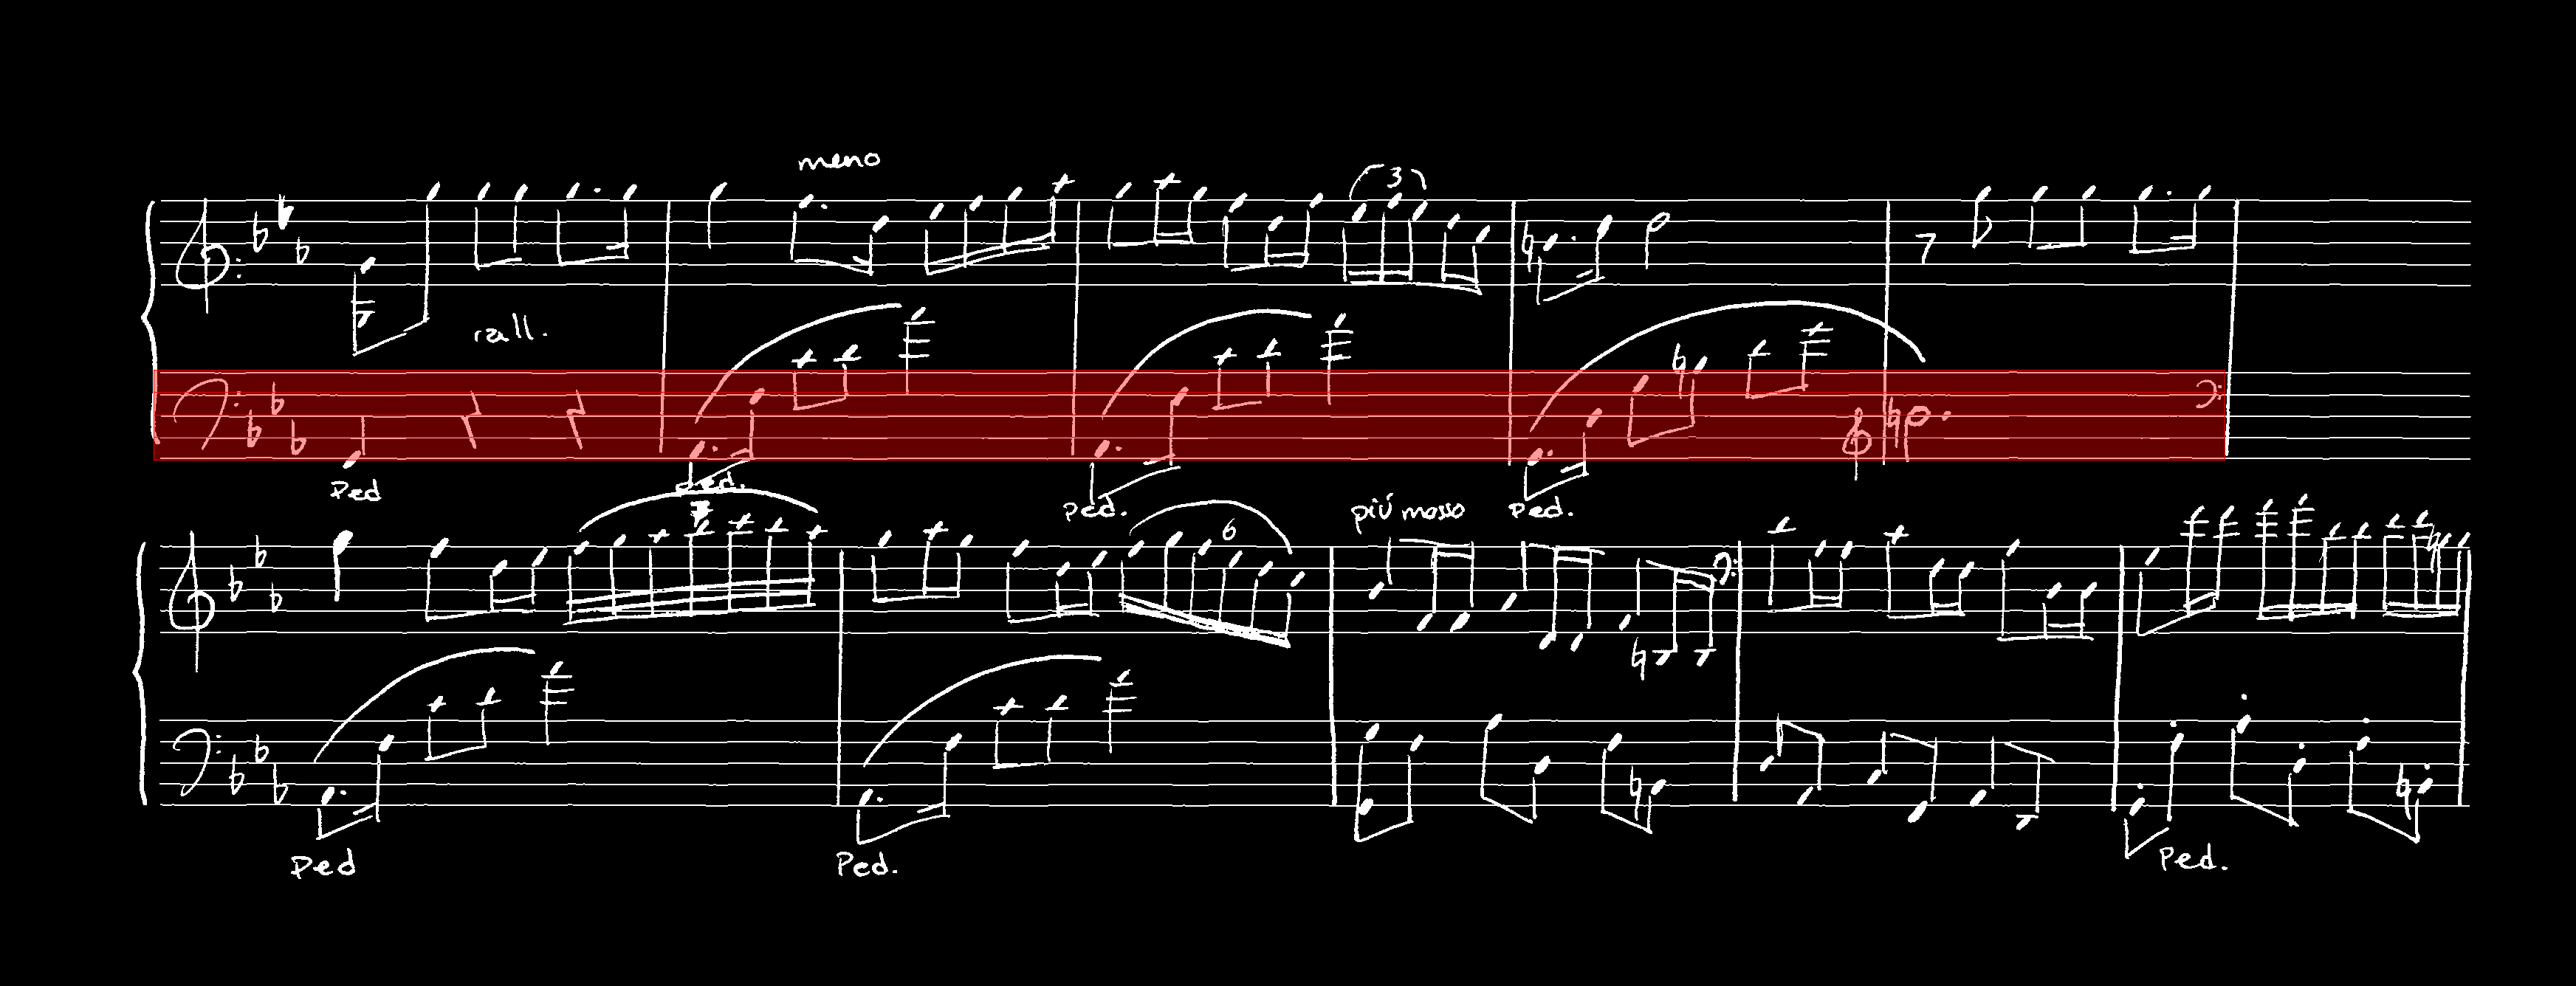

In [16]:

sample_image = (images[0]*255).type(torch.ByteTensor)

image_with_bb = draw_bounding_boxes(sample_image, torch.from_numpy(stafflineBBs), fill=True, colors="Red")

Image.fromarray(np.moveaxis(image_with_bb.numpy(), 0, -1))

In [ ]:
def get_staff_boundaries(measure_centers):
    

    pass


In [70]:
centers = (staff.stats['center'] for staff in staves)


for idx, measure in enumerate(centers):
    print(idx)


0
1
2
3
